## Playing around with `torch_dreams`

This simple library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

`torch_dreams` aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

**Note**: This is by no means a PyTorch equivalent of lucid. But rather it is a bunch of useful tools which have similar intent to that of lucid.

In this notebook, we test out `torch_dreams` while trying to visualize the features within the [VGG_19](https://arxiv.org/abs/1409.1556).

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch_dreams import utils
from torch_dreams.dreamer import dreamer

import torchvision.models as models 

### First off, let's load up the model
After loading up the model, we make 2 more lists:
* `conv_layers` contains the names of all the feature extraction layers within the VGG19
* `linear_layers` contains the names of all the linear layers including the output layer

In [2]:

model = models.vgg19(pretrained = True)
model.eval()

# print(list(model.parameters()))

conv_layers = list(model.features.children())
linear_layers = list(model.classifier.children())

# print(layers[0].weight.data)


### Initiating the `dreamer` 

In [3]:
dreamy_boi = dreamer(model)

dreamer init on:  cuda


### Deep-dreams w.r.t single layers 
Simple and straight, here we try to maximize the activations of the 18th layer as a whole. 

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]


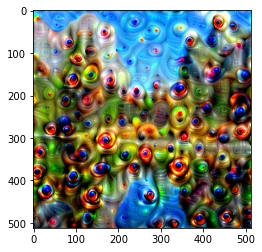

In [86]:
layers_to_use= conv_layers[18:19]

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 7,
    iterations =10,
    lr = 0.3,
)

plt.imshow(out)
plt.show()

### Deep-dreams w.r.t the output logits

We selected the last layer from `linear_layers` i.e `linear_layers[-1]`.

Setting `loss = layer_outputs[0][698]` means we'll be trying to maximize the value of the 698th category from the imageNet dataset i.e "palace". 

Check out [this gist](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) if you want to know all of the other classes in the ImageNet dataset.

100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


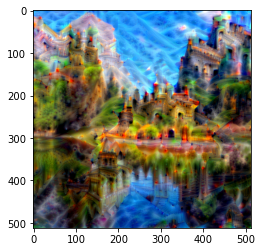

In [84]:
layers_to_use= linear_layers[-1:]

def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs

    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
    loss = layer_outputs[0][698]
    return loss


out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 7,
    iterations =35,
    lr = 1.3,
    custom_func = my_custom_func
)

plt.imshow(out)
plt.show()

### Deep-dreams w.r.t multiple layers

Optimizing on multiple layers is as easy as appending the `layers_to_use` list with the layer.



100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


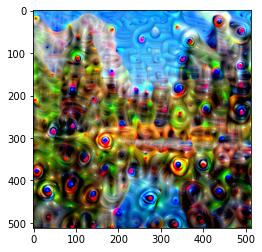

In [93]:
layers_to_use= [conv_layers[14], linear_layers[2], linear_layers[3]]

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 7,
    iterations =10,
    lr = 0.8,
    custom_func = None
)

plt.imshow(out)
plt.show()

## A deeper dive 

The `custom_func` arg in `torch_dreams.dreamer.deep_dream()` can be used for more specfic optimization based feature extractions. You can basically apply any custom function to the layer output(s) and use it to optimize the image. 

As seen below, we wrote a custom function `my_custom_func` that selects the first channel of the layer output for optimization. 

Optimizing the image w.r.t a single neuron unit from one of the channels could be as easy as:

```python

def custom_func(layer_outputs):    
    layer_index = 0
    channel_number = 0
    op = layer_outputs[layer_index][channel_number][0][0].norm() ## the very first unit
    return op

```


### Deep-dreams w.r.t individual channels of conv layers 

This time, we aim to optimize the 100th channel of the 14th feature extraction layer. Notice how `my_custom_func` is tweaked to extract the activations of the 100th channel with `loss = layer_outputs[0][100].norm()`

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


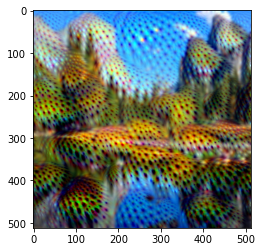

In [85]:
layers_to_use= conv_layers[14:15]

def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs
    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
#     print(layer_outputs[0].size())
    loss = layer_outputs[0][100].norm()
    return loss

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 7,
    iterations =15,
    lr = 0.3,
    custom_func = my_custom_func
)

plt.imshow(out)
plt.show()

### Weighted multi layer optimizations

Not as fancy as it sounds, but it opens up a lot of possibilities

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


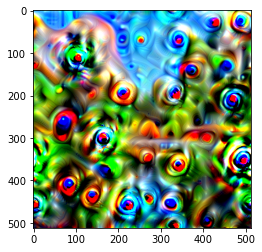

In [100]:
layers_to_use= [conv_layers[14], linear_layers[2], linear_layers[3]]

def my_custom_func(layer_outputs):

    alpha, beta, gamma = 0.8, 0.3, 0.7
    
    loss = layer_outputs[0].norm() * alpha + layer_outputs[0].norm() * beta + layer_outputs[0].norm() * gamma
    return loss

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 9,
    iterations =10,
    lr = 0.5,
    custom_func = my_custom_func
)

plt.imshow(out)
plt.show()

## Optimizing random noise to activate certain channels

254 0


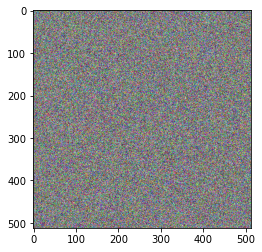

True

In [4]:
image_sample = (np.random.rand(512,512,3).astype(np.float32) *255).astype(np.uint8)
print(image_sample.max(), image_sample.min())
plt.imshow(image_sample)
plt.show()
cv2.imwrite("noise.jpg", image_sample)

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


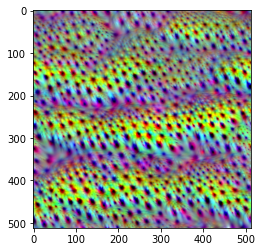

In [12]:
layers_to_use= conv_layers[14:15]

def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs
    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
    loss = layer_outputs[0][100].norm()
    return loss


out = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 10,
    iterations =15,
    lr = 0.4,
    custom_func = my_custom_func
)

plt.imshow(out)
plt.show()

In [7]:
layers_to_use= conv_layers[14:15]

all_vis  = []

for i in range(18):
    
    def my_custom_func(layer_outputs):
        """
        this custom func would get applied to the list of layer outputs

        the layers whose outputs are given here are the ones you asked for in the layers arg
        """
    #     print(layer_outputs[0].size())

        loss = layer_outputs[0][i+100].norm()
        return loss

    vis = dreamy_boi.deep_dream(
        image_path = "noise.jpg",
        layers = layers_to_use,
        octave_scale = 1.2,
        num_octaves = 14,
        iterations =15,
        lr = 0.4,
        custom_func = my_custom_func
    )
    all_vis.append(vis)

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


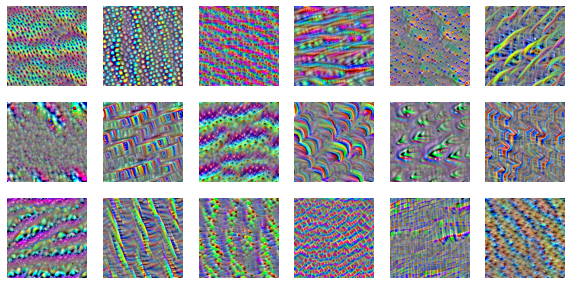

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize = (10,5))

for i in range(len(all_vis)):
    ax.flat[i].imshow(cv2.cvtColor(all_vis[i], cv2.COLOR_BGR2RGB))
    ax.flat[i].axis("off")
    ax.flat[i].set_facecolor("white")

##  Optimizing single units 

  0%|          | 0/13 [00:00<?, ?it/s]

on layer: [Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


100%|██████████| 13/13 [01:03<00:00,  4.88s/it]


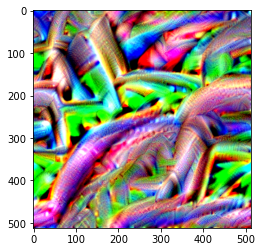

In [83]:
layers_to_use= conv_layers[-5:-4]
print("on layer:", layers_to_use)

def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs
    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
    loss = layer_outputs[0][10][0][0]
#     print(loss)
    return loss


out = dreamy_boi.deep_dream(
    image_path = "noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =150,
    lr = 1.9,
    custom_func = my_custom_func
)

plt.imshow(out)
plt.show()

In [ ]:
layers_to_use= conv_layers[-5:-4]
print("on layer:", layers_to_use)

all_vis = []
for i in range(15):
    def my_custom_func(layer_outputs):
        """
        this custom func would get applied to the list of layer outputs
        the layers whose outputs are given here are the ones you asked for in the layers arg
        """
        loss = layer_outputs[0][i][0][0]
    #     print(loss)
        return loss


    out = dreamy_boi.deep_dream(
        image_path = "noise.jpg",
        layers = layers_to_use,
        octave_scale = 1.2,
        num_octaves = 12,
        iterations =150,
        lr = 1.9,
        custom_func = my_custom_func
    )

#     plt.imshow(out)
#     plt.show()
    
    all_vis.append(out)

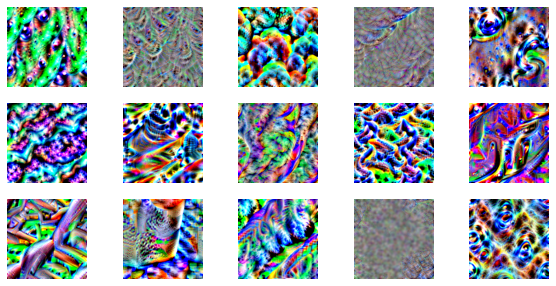

In [102]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize = (10,5))

for i in range(len(all_vis)):
    ax.flat[i].imshow(cv2.cvtColor(all_vis[i], cv2.COLOR_BGR2RGB))
    ax.flat[i].axis("off")
    ax.flat[i].set_facecolor("white")